Note: Use this template to develop your project. Do not change the steps. For each step, you may add additional cells if needed.

#### Group Information

Group No: Derma5

- Member 1: Zarif Irfan bin Khairussli (163470)
- Member 2: Iqmal Aidid bin Zakaria (163555)
- Member 3: Arif Hakim Bin Amir Hakim (161120)
- Member 4: Ahmad Hazwan Syauqee bin Husairi (164485)

#### Import Libraries

In [1]:
%config Completer.use_jedi=False
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

#### Load the dataset

In [2]:
dataset = pd.read_csv('classification_dataset.csv')
dataset.sample(10)

,f1,f2,f3,f4,f5,label
16,-1.494896,-5.102752,5.912392,6.074304,5.455614,1
834,10.160136,13.916993,-1.772845,-7.367318,13.929875,0
390,-5.826600,1.470007,6.573676,13.669585,4.293634,1
119,-4.431512,4.220060,7.707011,-2.602157,3.801321,0
362,2.864499,2.129677,16.132761,-2.320604,-0.292796,0
154,1.407007,4.559903,10.582799,11.417692,5.310664,1
823,-3.229555,2.733618,2.270249,-3.365433,4.322541,0
920,2.320014,-1.938325,2.841856,8.350827,3.374928,1
93,0.610071,8.116836,-0.863963,-7.114947,9.347659,0
356,-4.672923,0.586553,16.370864,3.707253,0.454410,1


In [3]:
dataset.shape

(1000, 6)

In [4]:
X = dataset.iloc[:, :-1].values  # Extract features (all columns except the last one)
y = dataset.iloc[:, -1].values   # Extract target labels (last column)

#### Define the loss function

In [5]:
def loss_fn(y_true, y_pred): #y_pred == y_hat
    """
    This function calculates the loss function using sigmoid cross-entropy loss.
    """
    y_true = tf.cast(y_true, dtype=tf.float64)  # Ensure y_true is of type float64
    y_pred = tf.cast(y_pred, dtype=tf.float64)  # Ensure y_pred is of type float64
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred))


#### Define function to perform prediction

In [6]:
def sigmoid(x):
    """
    This function calculates the sigmoid function.
    """
    return 1 / (1 + tf.exp(-x))

# Define function to perform ReLU activation
def relu(x):
    """
    This function calculates the ReLU function.
    """
    return tf.maximum(0, x) # so if x > 0, take the x, else return 0

# Define function to perform forward pass (predicts the label)
def forward(X, W1, b1, W2, b2):
    """
    This function calculates the forward pass (predicts the label).
    """
    X = tf.cast(X, dtype=tf.float64)  # Ensure X is of type float64
    h = relu(tf.add(tf.matmul(X, W1), b1)) # Forward pass through the hidden layer with ReLU activation
    logits = tf.add(tf.matmul(h, W2), b2) # Forward pass through the output layer
    return tf.squeeze(logits)  # Squeeze the logits to match the shape of labels



#### Define function for model training
Display the training and validation loss values for each epoch of the training loop. The displayed value must be in 6 decimal places.<br>
Hint: <br>
Use `tf.GradientTape` to compute the gradients.

In [7]:
def train(X, y, W1, b1, W2, b2, learning_rate):
    """
    This function performs the forward pass, computes the gradient and updates the weights and biases using gradient descent.
    """
    X = tf.cast(X, dtype=tf.float64)  # Ensure X is of type float64
    y = tf.cast(y, dtype=tf.float64)  # Ensure y is of type float64
    with tf.GradientTape() as tape:
        y_pred = forward(X, W1, b1, W2, b2)  # Forward pass
        loss = loss_fn(y, y_pred)  # Compute loss
    gradients = tape.gradient(loss, [W1, b1, W2, b2])  # Compute gradients
    # Update weights and biases using gradient descent
    W1.assign_sub(learning_rate * gradients[0])
    b1.assign_sub(learning_rate * gradients[1])
    W2.assign_sub(learning_rate * gradients[2])
    b2.assign_sub(learning_rate * gradients[3])
    return loss

#### Define function for model training with mini-batch gradient descent and early stopping

In [8]:
def fit(X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate, early_stopping_patience):
    """
    This function trains the model using mini-batch gradient descent and implements early stopping regularization.
    """
    train_losses = []  # List to store training losses for each epoch
    val_losses = []  # List to store validation losses for each epoch
    best_val_loss = float('inf')  # Initialize best validation loss
    best_epoch = 0  # Initialize epoch with best validation loss
    best_weights = None  # Initialize best weights
    patience = 0  # Initialize patience counter for early stopping
    
    for epoch in range(epochs):
        # Shuffle the training data
        indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]
        
        # Mini-batch gradient descent
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]
            train_loss = train(X_batch, y_batch, W1, b1, W2, b2, learning_rate)
        
        # Compute validation loss
        val_loss = loss_fn(y_val, forward(X_val, W1, b1, W2, b2))
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_weights = [W1.numpy(), b1.numpy(), W2.numpy(), b2.numpy()]
            patience = 0
        else:
            patience += 1
            if patience > early_stopping_patience:
                print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.6f}")
                break
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}")
    
    return best_weights, train_losses, val_losses


#### Define the tensors to hold the weights and biases (create the model)
Hint: <br>
Use `tf.Variable` to create the tensors.<br>
Put the tensors in a list.

In [9]:
n_input = dataset.shape[1] - 1  # number of features
n_hidden = 10  # number of units in the hidden layer/number of neurons in the hidden layer of the neural network.
n_output = 1  # number of output units

W1 = tf.Variable(tf.random.normal([n_input, n_hidden], dtype=tf.float64), name='weights1')
b1 = tf.Variable(tf.zeros([n_hidden], dtype=tf.float64), name='biases1')
W2 = tf.Variable(tf.random.normal([n_hidden, n_output], dtype=tf.float64), name='weights2')
b2 = tf.Variable(tf.zeros([n_output], dtype=tf.float64), name='biases2')


#### Split the dataset
The ratio of training and test is 7:1:2.

In [10]:
# Split the dataset into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training set into training and validation sets (70% training, 10% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125/0.7, random_state=42)

#### Normalize the data

In [11]:
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_val = (X_val - np.mean(X_val, axis=0)) / np.std(X_val, axis=0)
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

#### Set hyperparameters

In [12]:
epochs = 100 #number of times the entire dataset will be passed forward and backward through the neural network.
                # Can be 50 or even 300.
batch_size = 32 #number of samples that are propagated through the neural network
learning_rate = 0.01 #controls the size of the steps taken during gradient descent to update the model's parameters.
early_stopping_patience = 5 #number of epochs with no improvement in validation loss before 
                            #training is stopped to prevent overfitting. Perharps 5-10.


#### Train the model with mini-batch gradient descent and early stopping

In [13]:
best_weights, train_losses, val_losses = fit(X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate, early_stopping_patience)
# Returns the best weights obtained during training, along with the training and validation losses recorded during each epoch.

Epoch 1/100, Training Loss: 0.761692, Validation Loss: 1.569878
Epoch 2/100, Training Loss: 1.692758, Validation Loss: 1.258890
Epoch 3/100, Training Loss: 0.837261, Validation Loss: 1.031424
Epoch 4/100, Training Loss: 0.717337, Validation Loss: 0.860887
Epoch 5/100, Training Loss: 0.758264, Validation Loss: 0.730015
Epoch 6/100, Training Loss: 0.626477, Validation Loss: 0.628901
Epoch 7/100, Training Loss: 0.721042, Validation Loss: 0.548989
Epoch 8/100, Training Loss: 0.301858, Validation Loss: 0.486023
Epoch 9/100, Training Loss: 0.703365, Validation Loss: 0.433672
Epoch 10/100, Training Loss: 0.485642, Validation Loss: 0.391526
Epoch 11/100, Training Loss: 0.478229, Validation Loss: 0.356402
Epoch 12/100, Training Loss: 0.418752, Validation Loss: 0.326695
Epoch 13/100, Training Loss: 0.400081, Validation Loss: 0.301360
Epoch 14/100, Training Loss: 0.245097, Validation Loss: 0.279666
Epoch 15/100, Training Loss: 0.319231, Validation Loss: 0.260821
Epoch 16/100, Training Loss: 0.240

#### Set the best weights and biases

In [14]:
W1.assign(best_weights[0])
b1.assign(best_weights[1])
W2.assign(best_weights[2])
b2.assign(best_weights[3])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float64, numpy=array([-0.69612296])>

#### Display the weights and biases of both the hidden layer and the output layer

In [15]:
print("Weights of the hidden layer:")
print(W1.numpy())
print("\nBiases of the hidden layer:")
print(b1.numpy())
print("\nWeights of the output layer:")
print(W2.numpy())
print("\nBiases of the output layer:")
print(b2.numpy())

Weights of the hidden layer:
[[-0.15277552  0.18350107 -0.90769506  1.13961477 -0.02909554  0.02423389
   0.58667647  0.36165795  0.64021343  0.07313513]
 [-0.90565486  0.02066786 -1.08379276 -0.63085352  0.24873671 -0.10299757
  -0.52167496 -1.44602646 -1.27431423  0.87383809]
 [ 0.59907509  0.62342441 -1.49969187 -2.05043865 -2.34531228  0.81819661
   1.00198516 -0.87776546 -0.2930886  -0.16263321]
 [-0.76788543  0.96413367  0.74717765  2.28687355  0.28187026  1.59659177
   0.35597181  0.66534562  1.22516734 -1.65964228]
 [ 0.0206781   1.15214009  1.41690632  2.28608656  0.47454308  1.13132709
   1.6487288  -0.42096167  0.91879599 -1.19408621]]

Biases of the hidden layer:
[-0.44918373 -0.17214809 -0.00163304  0.00465662  0.04287569  0.1450922
 -0.09088632  0.25335216  0.18478126  0.33125831]

Weights of the output layer:
[[ 0.71160313]
 [ 0.74914086]
 [ 0.4293711 ]
 [-0.0928552 ]
 [-0.46891879]
 [ 1.02054492]
 [ 0.27655919]
 [ 1.06558825]
 [ 0.62656867]
 [-1.3729385 ]]

Biases of th

#### Display the training loss and validation loss against epoch graph

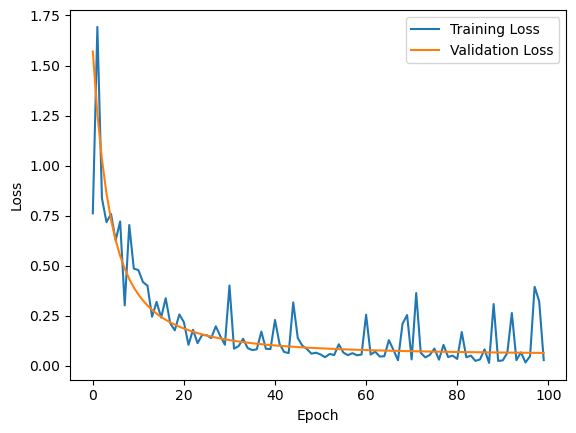

In [16]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Predict the test set

In [17]:
y_pred = tf.round(sigmoid(forward(X_test, W1, b1, W2, b2)))
y_pred = tf.squeeze(y_pred).numpy()


#### Display the confusion matrix and the classification report.

In [18]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[99  1]
 [ 1 99]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       100
           1       0.99      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

